# Extract and plot historical daily data(Basic variables)
* Since the data size is too large, please download the data from OCDP [Historical Data](http://lamps.math.yorku.ca/OntarioClimate/index_app_data.htm#/historicaldata)

* To run this program, it is neccesary to install: 
   - pandas;
   - numpy;
   - matplotlib and 
   - geopandas
---
*Programmer: Dr. Ziwang Deng, LAMPS, Department of Mathematics & Statistics, York University*

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from geopandas import GeoSeries
import scipy.io as sio
import datetime

In [7]:
# in the historical data, we ignored Feb 29 in leap years
def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

In [8]:
# Variable names: mean temperature; maximum temperature, minimum temperature and precipiation
varNames = ['tas','tasmax','tasmin','pr']
varName='tasmax'

In [9]:
# read and map the variable for the period from 1979-2016
# user can download historical data from OCDP website: 
# http://lamps.math.yorku.ca/OntarioClimate/index_app_data.htm#/historicaldata

matfile = '../data/data/Historical/' + varName + '_ECMWF_8964X365X38.mat'  
datacontent=sio.loadmat(matfile)
data = datacontent['outputData']/10.0   # the data in matfile is integer (real value *10), it must be divided by 10
print(np.shape(data))
print(type(data))

(8964, 365, 38)
<class 'numpy.ndarray'>


In [10]:
# We simplified the base four maps and saved them as geojson format, user can use other version base maps
# read basemap data in geojson files
lakefile='../shapefiles/Lake_Arc_simplify.geojson'
Municipal = '../shapefiles/Municipal_Arc_simplify.geojson'
Ontario = '../shapefiles/Ontario_arc.geojson'
OnPolygon = '../shapefiles/polygon9864.geojson'

# Ontario boundary
ont=gpd.read_file(Ontario)

# the lakes within Ontario
lake=gpd.read_file(lakefile)

# municipals
muni=gpd.read_file(Municipal)

# merge grid polygon and the data for plotting spatial variation map
cmp='jet'
poly=gpd.read_file(OnPolygon)

(8964,)


C:\Users\ldxd\Anaconda3\lib\site-packages\geopandas\plotting.py:385: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


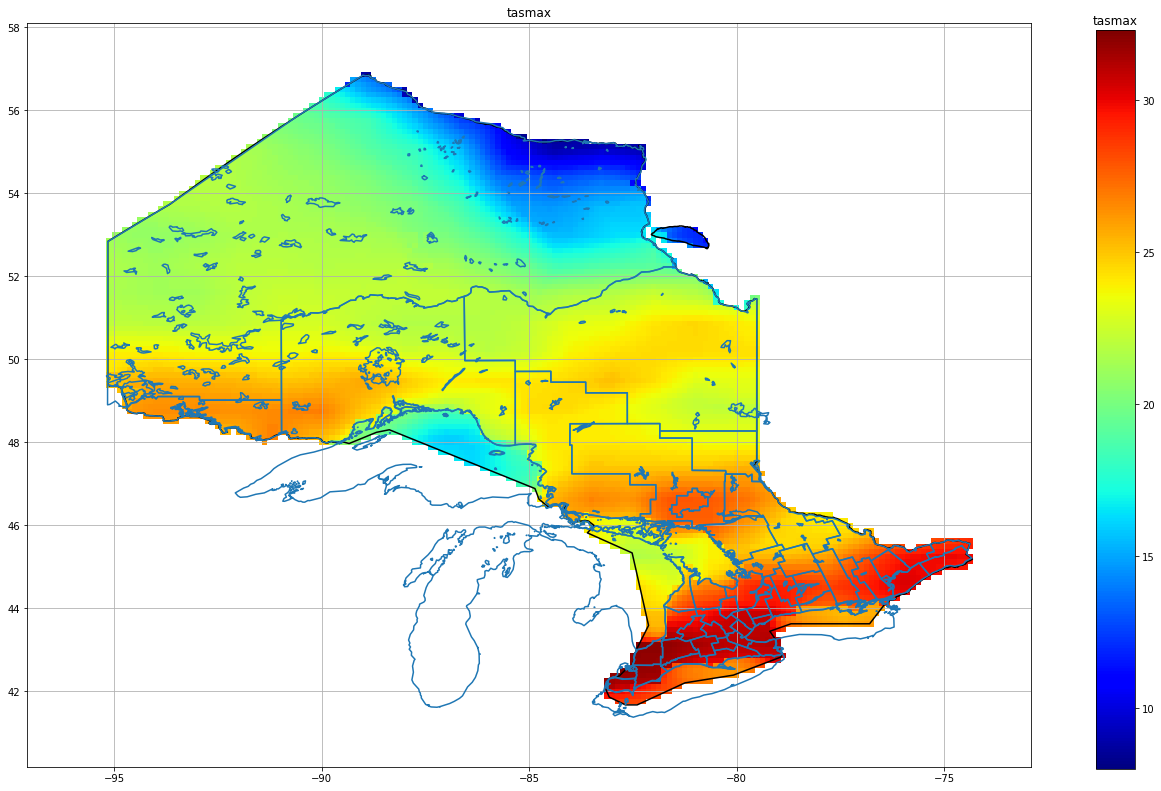

In [11]:
# display daily values on a map
# use can change this date (three values) to display weather map on different day
Year = 2016 # 1979-2016
Month = 7  # 1-12
Day = 28   # 

# extract the data on this specific day

theDate = datetime.date(Year,Month,Day)
# print(theDay)

theDayOfYear = theDate.timetuple().tm_yday
# print(theDayOfYear)

# our data does not include February 29 in leap year, so
if(is_leap_year(Year) and (theDayOfYear>59)):
    theDayOfYear=theDayOfYear-1
data_on_theDay = data[:,theDayOfYear-1,Year-1979]
print(np.shape(data_on_theDay))
data2map = pd.DataFrame(data_on_theDay,columns=['values'])
data2map['id']=pd.DataFrame(np.arange(1,8964))

# plot the background
p1=Polygon([(-96,41),(-74,41),(-74,57.3),(-96,57.3)])
g = GeoSeries(p1)
base=g.plot(color='white', edgecolor='white', figsize=(18,27))
ont.plot(ax=base, color='black', edgecolor='black')

# plot maps
lake.plot(ax=base)
muni.plot(ax=base)
polydata=poly.merge(data2map, on='id')
ax = polydata.plot(ax=base, column='values', colormap=cmp,vmin=min(polydata['values']),vmax=max(polydata['values']))

# setting legend
# thanks to: https://stackoverflow.com/questions/54236083/geopandas-reduce-legend-size-and-remove-white-space-below-map
ax.set_title(varName)
ax.grid() 
fig = ax.get_figure()
# here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)

cbax = fig.add_axes([0.95, 0.31, 0.03, 0.38])   
cbax.set_title(varName)

sm = plt.cm.ScalarMappable(cmap=cmp,norm=plt.Normalize(vmin=min(polydata['values']), vmax=max(polydata['values'])))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%d")
plt.show()



(10950, 7)
10950


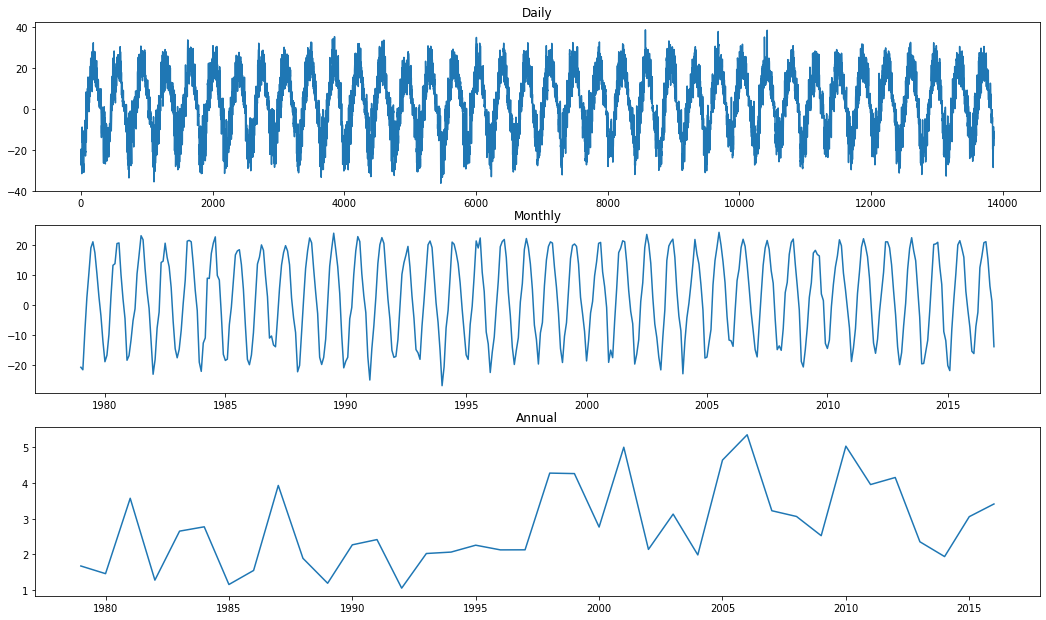

In [12]:
# following, we will plot time series at a specific location (latitude, longitude)
grids = pd.read_csv('../data/data/Historical/LAMPS_Ontario_8964Pts.csv')
# print(grids.columns)
lon=-84
lat=54
grids1=grids[abs(grids.Latitude-lat)<0.06251]
# print(grids1.columns)
grids2=grids1[abs(grids1.Longitude-lon)<0.06251]
if len(grids2) <1:
    print('sorry, your point is not in Ontario')
else:
    if len(grids2) ==1:
        timeseriesData= np.reshape(data[grids2.ID,:,:],(365,38))
        # print(np.shape(timeseriesData))
    else:
        tmp=data[grids2.ID,:,:]
        print(np.shape(tmp))
        timeseriesData=np.reshape(np.mean(tmp,axis=0),(365,38))
fig2 = plt.figure(figsize=(18,18))
ax1=plt.subplot(5,1,1)
plt.plot(timeseriesData.T.flatten())

# following we generate date range and calculate monthly mean, annuan mean
annualMean = np.mean(timeseriesData,axis=0)
Yrs = np.arange(38)+1979
ax3=plt.subplot(5,1,3)
plt.plot(Yrs,annualMean)
start=datetime.datetime.strptime('01-01-1979','%d-%m-%Y')
end = datetime.datetime.strptime('01-01-2017','%d-%m-%Y')
dates = [start + datetime.timedelta(days=x) for x in range(0,(end-start).days)]
# delete February 29
dates1 = [x for x in dates if not ((x.month == 2) and (x.day == 29))]

df_data = pd.DataFrame(dates1,columns =['date'])
df_data['year'] = [x.year for x in dates1]
df_data['monthinyear'] = [x.month for x in dates1]
df_data['dayinmonth'] = [x.day for x in dates1]

df_data['weekinyear'] = [x.isocalendar()[1] for x in dates1]
df_data['dayinweek'] = [x.isocalendar()[2] for x in dates1]
df_data['values'] = timeseriesData.T.flatten()
# print(df_data.head(40))

# df_data.to_csv('replace with your path where you want to store the csv file/wantedcsvfilename.csv')

monthlyMean = df_data.groupby(['year','monthinyear'],as_index=False).agg({"values": "mean"})
# extract 30-yrs data 1981-2010
data30Yrs = df_data[df_data['year'] > 1980]

data30Yrs = data30Yrs[data30Yrs['year'] < 2011]                      
print(np.shape(data30Yrs))

# monthly30YrsMean = df_data.group
# print(monthlyMean.head(10)) 
ax2=plt.subplot(5,1,2)
plt.plot(monthlyMean.year+(monthlyMean.monthinyear-1)/12,monthlyMean['values']) 

ax1.title.set_text('Daily')
ax2.title.set_text('Monthly')
ax3.title.set_text('Annual')
print(365*30)